# Benchmarking for predicting Radiative heating using a heating-rate plus boundary fluxes approach and a convolutional NN

The purpose of this notebook is to benchmark one possible solution to the problem. This approach aims to predict the heating rates and boundary-fluxes for short-wave heating. We will aim to directly predict the heating rate and surface fluxes (both down and up). Then invoking conservation of energy we will vertically integrate the heating rate to determine the net top-of-atmosphere (TOA) flux. From this, the outgoing TOA flux could be deduced, as the downwards flux is prescribed as the incoming solar radiation (for shortwave) or 0 (for longwave).

We will use a convolutional neural network, we will add dilation to first convolutional layers to allow information to propagate more quickly through the vertical column.

In [1]:
#If you do not yet have climetlab and the radiation dataset.

#pip install climetlab
#pip install climetlab_maelstrom_radiation

In [2]:
#If running on EuropeanWeatherCloud to avoid redownloading data
import os
os.environ['CLIMETLAB_MIRROR']='https://storage.ecmwf.europeanweather.cloud file:///mnt'
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
import climetlab as cml

2021-12-01 09:26:51.487461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 09:26:51.502948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 09:26:51.503688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Create datasets for training and validation
This uses quite a large amount of data, which was found to be necessary ...
We precscribe a training and validation dataset using the timestep and filenum arguments. 
Here we are trying to predict the shortwave fluxes 'sw' and the shortwave heating rate 'hr_sw'.
We set the heating rate units to be 'K d-1' instead of 'K s-1', so that the output is O(1).

In [20]:
batch_size = 512

big_data = False

if big_data:
    ds_cml = cml.load_dataset('maelstrom-radiation-tf',dataset='tripleclouds',
                      output_fields=['sw','hr_sw'],
                      timestep=list(range(0,3501,500)),
                      filenum = list(range(0,51,5)),
                      hr_units = 'K d-1',
                      norm=False,
                      #Note we add this to previous notebooks to change the outputs
                      minimal_outputs = True,
                      topnetflux = True,
                             )
else:
    ds_cml = cml.load_dataset('maelstrom-radiation-tf',dataset='tripleclouds',
                      hr_units = 'K d-1',
                      output_fields=['sw','hr_sw'],
                      norm=False,
                      #Note we add this to previous notebooks to change the outputs
                      minimal_outputs = True,
                      topnetflux = True,
          )

if big_data:
    ds_cml_val = cml.load_dataset('maelstrom-radiation-tf',
                         dataset='tripleclouds',
                         timestep=2019013100,
                         filenum = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         output_fields = ['hr_sw','sw'],
                         hr_units = 'K d-1',
                         norm = False,
                         #Note we add this to previous notebooks to change the outputs
                         minimal_outputs = True,
                         topnetflux = True,
                        )
else:
    ds_cml_val = cml.load_dataset('maelstrom-radiation-tf',
                         dataset='tripleclouds',
                         timestep=2019013100,
                         filenum = [0],
                         output_fields = ['hr_sw','sw'],
                         hr_units = 'K d-1',
                         norm = False,
                         #Note we add this to previous notebooks to change the outputs
                         minimal_outputs = True,
                         topnetflux = True,
                        )    


train = ds_cml.to_tfdataset(batch_size=batch_size,shuffle=True)

val = ds_cml_val.to_tfdataset(batch_size=batch_size,shuffle=False)



  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv1D,Add,RepeatVector,ZeroPadding1D,Reshape
from tensorflow.keras.layers import Cropping1D,Concatenate,Multiply,Flatten,Dense
from tensorflow import nn
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [6]:
#Custom layer to calculate the top net flux from the heating rate profile,
# surface fluxes and pressures.
@tf.keras.utils.register_keras_serializable()
class TopFlux(tf.keras.layers.Layer):
    def __init__(self,name=None,**kwargs):
        super(TopFlux, self).__init__(name=name,**kwargs)
        self.g_cp = tf.constant(9.80665 / 1004 * 24 * 3600)

    def build(self, input_shape):
        pass

    def call(self, inputs):
        fluxes = inputs[0]
        hr = tf.squeeze(inputs[1])
        hlpress = inputs[2]
        #Net surface flux = down - up
        netflux = fluxes[...,0] - fluxes[...,1]
        #Pressure difference between the half-levels
        net_press = hlpress[...,1:,0]-hlpress[...,:-1,0]
        #Integrate the heating rate through the atmosphere
        hr_sum = tf.math.reduce_sum(tf.math.multiply(hr,net_press),axis=-1)
        #Stack the outputs
        # TOA net flux, Surface down, #Surface up
        # upwards TOA flux can be deduced as down flux is prescribed
        # either by solar radiation for SW (known) or 0 for LW.
        return tf.stack([netflux + hr_sum / self.g_cp,fluxes[...,0],fluxes[...,1]],axis=-1)


In [7]:
#Load normalisation (the column max for each feature)
#this file is stored with the notebook (in case linking doesn't work)
import numpy as np
norms = np.load('inp_max_norm.npy',allow_pickle=True)
norms = norms[()]
for key in norms:
    norms[key][norms[key]==0] = 1
norms

{'sca_inputs': array([3.4412103e+02, 9.9760216e-01, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 9.0557474e-01, 8.5934466e-01, 8.6474800e-01,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 9.0621883e-01,
        9.0155667e-01, 9.0155667e-01, 9.9000025e-01, 1.0012065e+00,
        1.4071930e+03], dtype=float32),
 'col_inputs': array([3.02850120e-02, 1.75108307e-05, 4.25841426e-04, 3.32709419e-07,
        2.05031301e-06, 2.09439978e-01, 8.65664040e-10, 4.97483610e-10,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 7.81228415e-09,
        3.06694574e-07, 3.72612533e-07, 1.16950666e-07, 3.83020847e-07,
        5.07950915e-07, 3.52568293e-07, 2.95319722e-07, 1.50701158e-08,
        3.90490698e-08, 2.67124456e-08, 4.74221939e-10, 4.32739034e-03,
        1.22224241e-02, 2.99999992e-05, 1.00675599e-04], dtype=float32),
 'hl_inputs': array([   330.89767, 107193.51   ], dtype=float32),
 'inter_inputs': array([0.9932044], dtype=float32),
 'pressure_hl': array([107193.51], dt

In [22]:
#Here we construct a model.
    
def buildmodel(
    input_shape,
    output_shape,
    kernel_width = 5,
    conv_filters = 64,
    dilation_rates =  [1,2,4,8,16],
    conv_layers = 6,
    flux_layers = 3,
    flux_filters = 8,
    flux_width = 32,
    batch_norm = False,
              ):
    inputs = {}

    #Inputs are a bit messy, in the next few lines we create the input shapes,    
    for k in input_shape.keys():
        inputs[k] = Input(input_shape[k].shape[1:],name=k)
        
    # Calculate the incoming solar radiation before it is normalised.
    in_solar = inputs['sca_inputs'][...,1:2]*inputs['sca_inputs'][...,-1:]
    #Pressure needs to be un-normalised.
    hl_p = inputs['pressure_hl']
    
    #Normalise them by the columnar-maxes
    normed = {}
    for i,k in enumerate(input_shape.keys()):
        normed[k]= inputs[k]/tf.constant(norms[k])
    
    # and repeat or reshape them so they all have 138 vertical layers
    rep_sca = RepeatVector(138)(normed['sca_inputs'])
    col_inp = ZeroPadding1D(padding=(1,0))(normed['col_inputs'])
    inter_inp = ZeroPadding1D(padding=(1,1))(normed['inter_inputs'])
    all_col = Concatenate(axis=-1)([rep_sca,col_inp,normed['hl_inputs'],inter_inp])

    #Use dilation to allow information to propagate faster through the vertical.
    for drate in dilation_rates:
        all_col = Conv1D(filters=conv_filters,kernel_size = kernel_width,
                         dilation_rate = drate,padding='same',
                         data_format='channels_last',
                         activation = nn.swish)(all_col)
    #Regular conv layers
    for i in range(conv_layers):
        all_col = Conv1D(conv_filters,
                         kernel_size=kernel_width,
                         strides=1,padding='same',
                         data_format='channels_last',
                        )(all_col)

    #Predict single output, the heating rate.
    sw = Conv1D(filters=1,padding='same',kernel_size=kernel_width,
                data_format='channels_last',
                activation='linear')(all_col)
    
    #Crop the bottom value to make output correct size.
    #Perhaps you can think of a better solution?
    sw_hr = Cropping1D((0,1),name='hr_sw')(sw)
    
    #Reduce the number of features
    flux_col = Conv1D(filters=flux_filters,padding='same',kernel_size=kernel_width,
                      activation=nn.swish)(all_col)
    flux_col = Flatten()(flux_col)
    swf = Concatenate(axis=-1)([flux_col,normed['sca_inputs']])
    #Add a few dense layers, plus the input scalars
    for i in range(flux_layers):
        swf = Dense(flux_width,activation=nn.swish)(swf)
    swf = Dense(2,activation = 'sigmoid')(swf)
    swf = Multiply()([swf,in_solar])
    swf = TopFlux(name='sw')([swf,sw_hr,hl_p])

    
    #Dictionary of outputs
    output = {'hr_sw':sw_hr,
             'sw':swf}

    model = Model(inputs,output)
    model.compile(loss={'hr_sw':'mse',
                        'sw':'mse'},
                  loss_weights = {'hr_sw':10**(2),
                        'sw':1},
                  optimizer=Adam(10**(-5)))
    return model

In [23]:
#Get input and output shapes
input_shape = train.element_spec[0]
output_shape = train.element_spec[0]
#Build a model
model = buildmodel(input_shape,output_shape)

In [24]:
#Train the model. 
#On a V100, with slow-ish data connection, this takes 43ms/step.
# NB big_data = 6million samples, or 11660 batches of 512.
model.fit(train,validation_data=val,epochs=1)

11660/11660 [==============================] - 508s 43ms/step - loss: 2145.5464 - hr_sw_loss: 6.2883 - sw_loss: 1516.7190 - val_loss: 645.4091 - val_hr_sw_loss: 2.4590 - val_sw_loss: 399.5097


# Only proceed if you care about science metrics and plotting ....

In [25]:
#Only run if you care about science metrics and plotting ....
hist = model.fit(train,validation_data=val,epochs=50)

Epoch 1/50
11660/11660 [==============================] - 499s 43ms/step - loss: 448.2896 - hr_sw_loss: 1.8926 - sw_loss: 259.0304 - val_loss: 401.6278 - val_hr_sw_loss: 1.4753 - val_sw_loss: 254.1008
Epoch 2/50
11660/11660 [==============================] - 494s 42ms/step - loss: 310.6859 - hr_sw_loss: 1.2807 - sw_loss: 182.6147 - val_loss: 287.1633 - val_hr_sw_loss: 1.0816 - val_sw_loss: 179.0002
Epoch 3/50
11660/11660 [==============================] - 496s 42ms/step - loss: 248.2423 - hr_sw_loss: 1.0083 - sw_loss: 147.4113 - val_loss: 238.0648 - val_hr_sw_loss: 0.8949 - val_sw_loss: 148.5733
Epoch 4/50
11660/11660 [==============================] - 506s 43ms/step - loss: 215.4387 - hr_sw_loss: 0.8656 - sw_loss: 128.8740 - val_loss: 222.1483 - val_hr_sw_loss: 0.7939 - val_sw_loss: 142.7614
Epoch 5/50
11660/11660 [==============================] - 506s 43ms/step - loss: 194.3087 - hr_sw_loss: 0.7769 - sw_loss: 116.6151 - val_loss: 199.7363 - val_hr_sw_loss: 0.7031 - val_sw_loss: 129.

## What are good numbers?
Ideally we would like val_hr_sw_mse ~ 0.002 and val_sw_mse ~ 30.

Typically, with this model you will get val_hr_sw_mse ~ 0.25 and val_sw_mse ~ 30

## Quick visualisation of the results

In [26]:
#Grab the first batch of data.
for inps,outs in val:
    break
    
#Predict the outputs
pred = model.predict(inps)

In [27]:
import matplotlib.pyplot as plt

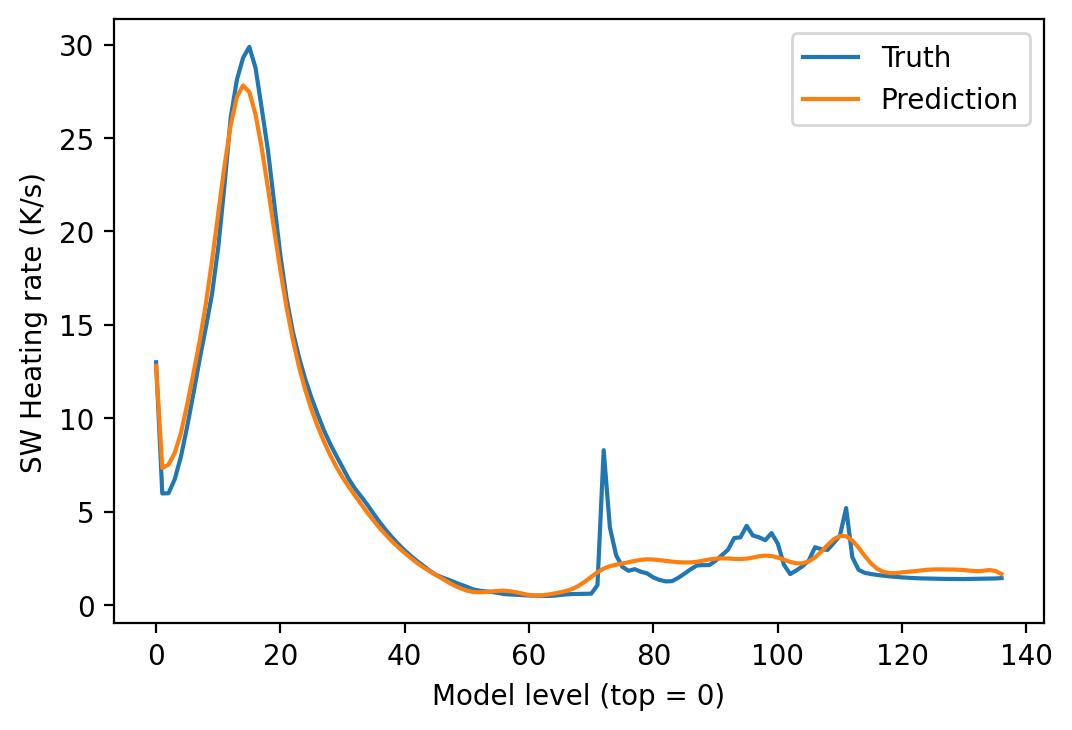

In [28]:
#Plot the first element of the batch
plt.figure(dpi=200)
plt.plot(outs['hr_sw'][0,:],label='Truth')
plt.plot(pred['hr_sw'][0,:],label='Prediction')
plt.ylabel('SW Heating rate (K/s)')
plt.xlabel('Model level (top = 0)')
plt.legend()

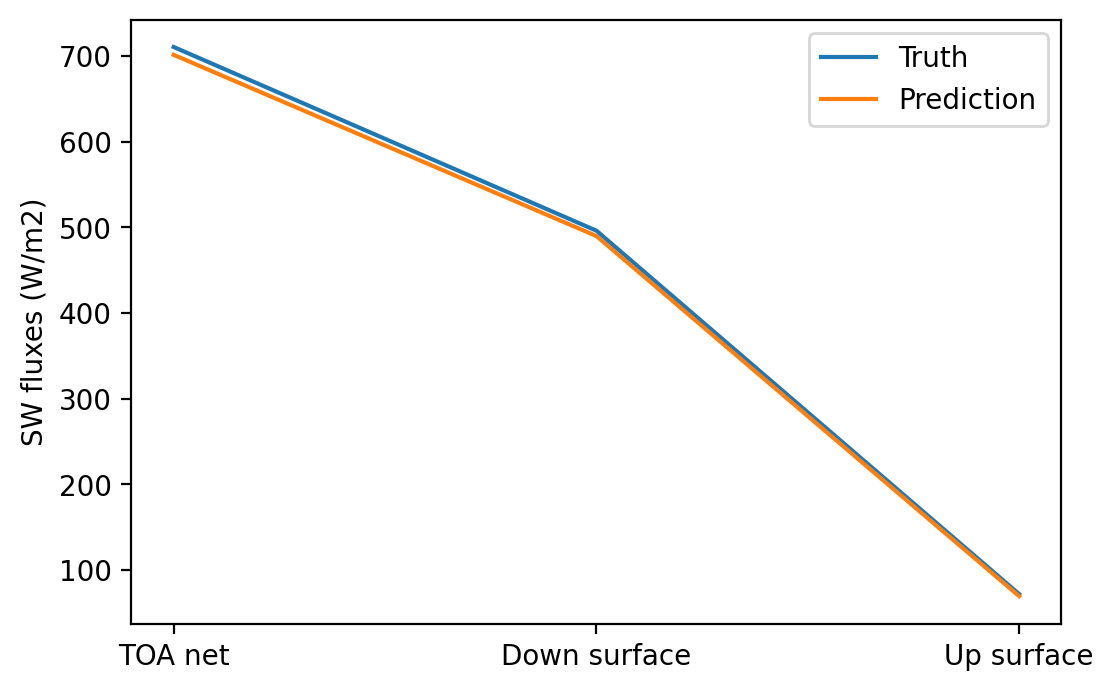

In [30]:
#Plot the downwards fluxes
xlabels = ['TOA net','Down surface','Up surface']
plt.figure(dpi=200)
plt.plot(xlabels,outs['sw'][0,:],label='Truth')
plt.plot(xlabels,pred['sw'][0,:],label='Prediction')
plt.ylabel('SW fluxes (W/m2)')
plt.legend()

# What have we learnt?
This model marks an improvement on the heating rates of the scaled flux approach, but still fails to capture all the heating rate fluctuations.
Further training can reduce the error further, or by using more data.

### Perhaps you can think of improvements to our convolutional model?